# Tree based methods for prediction

This tutorial is meant to be an introduction to tree based methods for prediction. We start with the most basic model, a decision tree, and work our way up to the more recent work on gradient boosting. We will be alternating between sample datasets available with sci-kit learn and a medical dataset made available in this repository.

In [11]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import datasets
import pydotplus

import matplotlib.pyplot as plt

# used to display trees
from IPython.display import Image

%matplotlib inline

Below we define a helper function which will help us plot (i) the decision that the tree makes as the background colour and (ii) the actual data coloured with their true outcome. So, if blue overlaps with blue on our plot, we can be fairly happy that the algorithm is working well. Note that while there are more rigorous and quantitative forms of evaluating models, one can gain a lot of insight from visualizing the data.

In [19]:
plt.colormaps()

[u'Accent',
 u'Accent_r',
 u'Blues',
 u'Blues_r',
 u'BrBG',
 u'BrBG_r',
 u'BuGn',
 u'BuGn_r',
 u'BuPu',
 u'BuPu_r',
 u'CMRmap',
 u'CMRmap_r',
 u'Dark2',
 u'Dark2_r',
 u'GnBu',
 u'GnBu_r',
 u'Greens',
 u'Greens_r',
 u'Greys',
 u'Greys_r',
 u'OrRd',
 u'OrRd_r',
 u'Oranges',
 u'Oranges_r',
 u'PRGn',
 u'PRGn_r',
 u'Paired',
 u'Paired_r',
 u'Pastel1',
 u'Pastel1_r',
 u'Pastel2',
 u'Pastel2_r',
 u'PiYG',
 u'PiYG_r',
 u'PuBu',
 u'PuBuGn',
 u'PuBuGn_r',
 u'PuBu_r',
 u'PuOr',
 u'PuOr_r',
 u'PuRd',
 u'PuRd_r',
 u'Purples',
 u'Purples_r',
 u'RdBu',
 u'RdBu_r',
 u'RdGy',
 u'RdGy_r',
 u'RdPu',
 u'RdPu_r',
 u'RdYlBu',
 u'RdYlBu_r',
 u'RdYlGn',
 u'RdYlGn_r',
 u'Reds',
 u'Reds_r',
 u'Set1',
 u'Set1_r',
 u'Set2',
 u'Set2_r',
 u'Set3',
 u'Set3_r',
 u'Spectral',
 u'Spectral_r',
 u'Wistia',
 u'Wistia_r',
 u'YlGn',
 u'YlGnBu',
 u'YlGnBu_r',
 u'YlGn_r',
 u'YlOrBr',
 u'YlOrBr_r',
 u'YlOrRd',
 u'YlOrRd_r',
 u'afmhot',
 u'afmhot_r',
 u'autumn',
 u'autumn_r',
 u'binary',
 u'binary_r',
 u'bone',
 u'bone_r',
 u'b

In [12]:
def plot_model_pred_2d(mdl, X, y, feat):
    # look at the regions in a 2d plot
    # based on scikit-learn tutorial plot_iris.html

    # get minimum and maximum values
    x0_min = X[:, 0].min()
    x0_max = X[:, 0].max()
    x1_min = X[:, 1].min()
    x1_max = X[:, 1].max()

    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                         np.linspace(x1_min, x1_max, 100))

    Z = mdl.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the contour - colouring different regions
    cs = plt.contourf(xx, yy, Z, cmap='Blues')

    # plot the individual data points - colouring by the *true* outcome
    color = y.ravel()
    plt.scatter(X[:, 0], X[:, 1], c=color, marker='o', s=40, cmap='Blues')

    plt.xlabel(feat[0])
    plt.ylabel(feat[1])
    plt.axis("tight")
    plt.colorbar()

# Dataset

The dataset we'll use is a classic: Fisher's iris. This data was collected by Fisher and includes the petal and sepal measurements for three types of flowers. The below code loads in the dataset, prints out a brief description, and extracts the data into `X` and the class labels into `y`. Note that we only use two columns of data because we'd like to visualize the classifier. Also, we only use data from index `50` onward because we'd like to focus on only two plants: versicolour and virginica.

In [27]:
# real example
df = datasets.load_iris()

# if you want a description of the dataset, uncomment the below line
print(df['DESCR'])

idx = [0,2]
X = df['data'][50:,idx]
y = df['target'][50:]

feat = [df['feature_names'][x] for x in idx]

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

# Decision trees

Let's build the simplest tree model we can think of: a classification tree with only one split. Decision trees of this form are commonly referred to under the umbrella term Classification and Regression Trees (CART) [1]. While we will only be looking at classification here, regression isn't too different.

[1] L. Breiman, J. Friedman, R. Olshen, and C. Stone. Classification and Regression Trees. Wadsworth, Belmont, CA, 1984.

This model will split the data into two groups, and predict classes for those two groups based on majority vote. There are many parameters available for the `DecisionTreeClassifier` class; by specifying `max_depth=1` we will build a decision tree with only one split - i.e. of depth 1.

In [28]:
# instantiate an instance of our tree with the parameters we would like
mdl = tree.DecisionTreeClassifier(max_depth=1)

# fit the model to the data - trying to predict y from X
mdl = mdl.fit(X,y)

Since our model is so simple, we can actually look at the full decision tree.

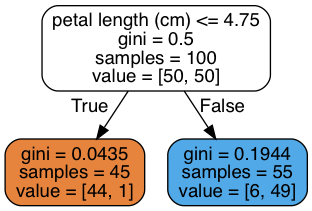

In [29]:
tree_graph = tree.export_graphviz(mdl, out_file=None,
                         feature_names=feat, 
                         filled=True, rounded=True)  
graph = pydotplus.graphviz.graph_from_dot_data(tree_graph) 
Image(graph.create_png())  

The top (white) node is the root of the tree: it contains all the data. Let's read this node bottom to top, starting with `value = [50, 50]`. This line is telling us the current class balance: there are `50` observations of class 1, and `50` observations of class 2. In our iris data, that translates to `50` versicolour and `50` virginica. Moving up a line, `samples = 100` reminds us how many rows of data are assessed at this node. Since it's the root of our tree, all the data is assessed. Moving up again we have `gini = 0.5`. This is the Gini index, and is very important as it is the value that is used to split data. The Gini index is a measure of impurity - the higher the value is, the bigger mix of classes that you have. Right now we have a 50/50 split of two classes, and as a result, the gini index is `0.5`: about as bad as we can do. Ideally, we'd want this value to be 0, which would indicate that only one class of data is present in that node.

Finally, the top line in the white node indicates what value we have split the data on - in this case we've moved observations with petal length <= 4.75 cm to the left node, and observations with petal length > 4.75 cm into the right node. Looking in the two nodes, we can also see that the value for `gini` is lower in both, indicating that these nodes are more homogenous. Looking at the `value` line, we can see that the left node has 44 observations in class 1, and 1 observation in class 2. This is much better than the 50/50 split we had earlier!

It's nice to look at the `gini` coefficient because that's actually what the algorithm uses to determine a split. It evaluates every single feature (petal length, etc) at every possible split (4.75, 4.76, ...) to find the split which minimizes the gini in the two resultant nodes.

Let's take a look at what this decision boundary actually looks like.

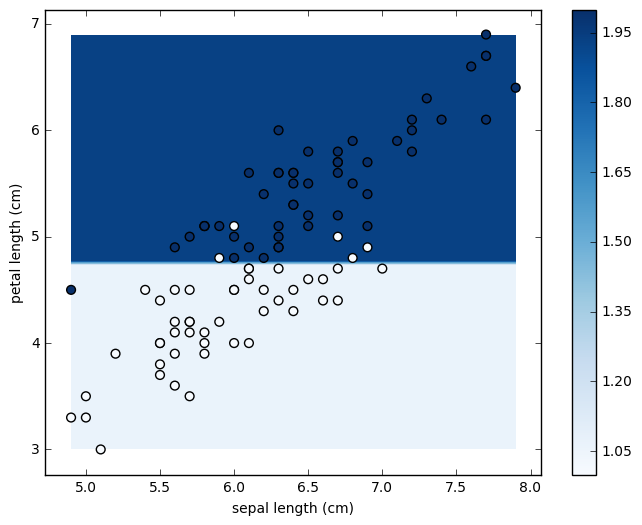

In [30]:
# look at the regions in a 2d plot
# based on scikit-learn tutorial plot_iris.html
plt.figure(figsize=[8,6])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

Above we can see the decision boundary of 4.75 cm for petal length (y-axis). We can also see on the far left the 1 point we misclassified as class 2 which had petal length < 4.75cm.

Of course we are using a very simple model - let's see what happens when we increase the depth to 5.

In [31]:
mdl = tree.DecisionTreeClassifier(max_depth=5)
mdl = mdl.fit(X,y)

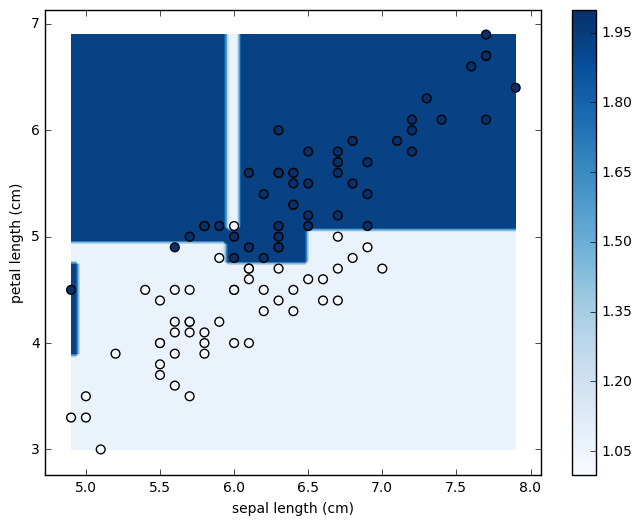

In [32]:
plt.figure(figsize=[8,6])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

Now our tree is more complicated - we can see a few vertical boundaries as well as the horizontal one from before. Some of these we may like - for example the movement of the boundary upward around septal length of ~6.7 cm. However, some feel very much like they aren't reflecting reality - the bar of classification done around a septal length of 6.1 cm, for example. Let's look at the tree itself.

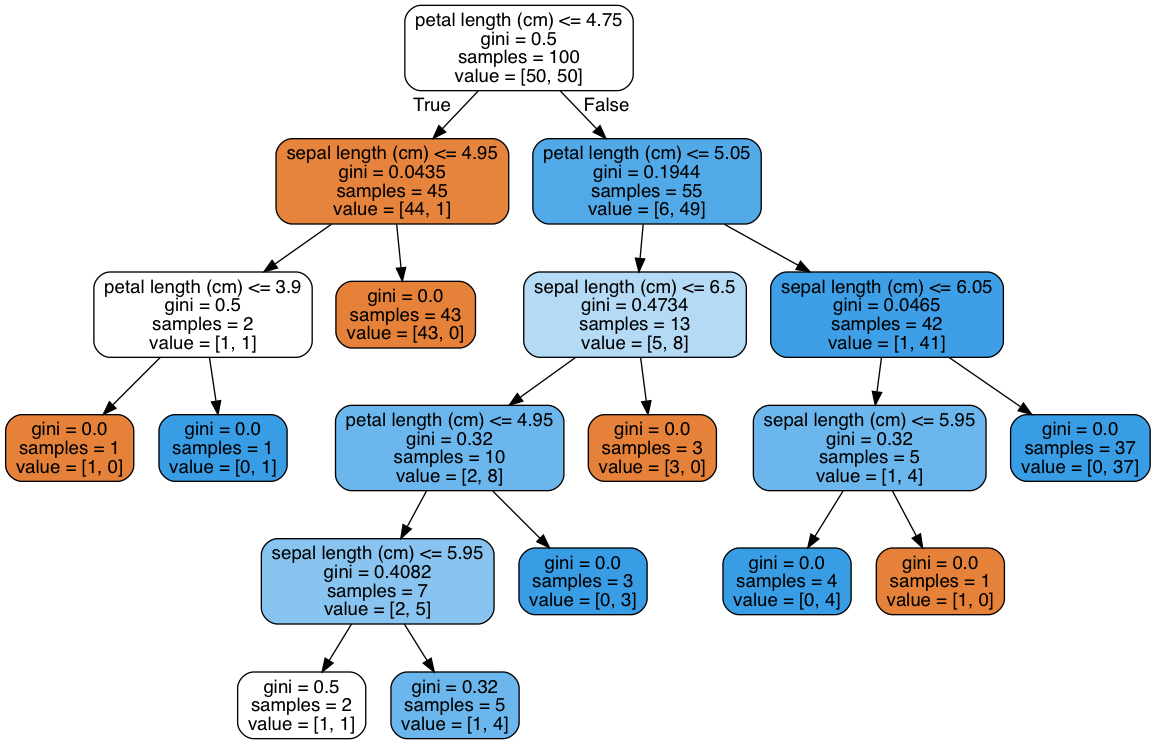

In [36]:
tree_graph = tree.export_graphviz(mdl, out_file=None,
                         feature_names=feat, 
                         filled=True, rounded=True)  
graph = pydotplus.graphviz.graph_from_dot_data(tree_graph) 
Image(graph.create_png())  

On the far right we see our culprint: if the sepal length <= 6.05, and it is > 5.95, we classify it as class 1. Having an entire rule based upon this one observation seems silly, but it's perfectly logical as at the moment the **only** objective the algorithm cares about is minimizing the gini - and a `gini = 0.0` is lower than a `gini = 0.0465` - so it continues splitting until it gets there.

This is where "pruning" the tree comes in (trust me, the gardening influenced play on words is just starting).

In [37]:
#TODO: pruning

## Decision trees have high "variance"

Before we move on to boosting, it will be useful to demonstrate how decision trees have high "variance". In this context, variance refers to a property of some models to have a wide range of performance given random samples of data. Let's take a look at randomly slicing the data we have too see what that means.

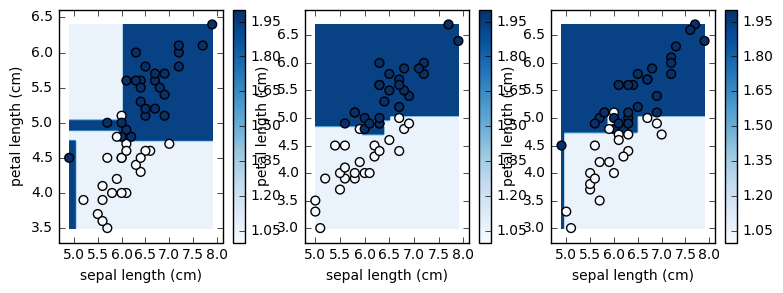

In [53]:

np.random.seed(123)

fig = plt.figure(figsize=[9,3])
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    
    # generate indices in a random order
    idx = np.random.permutation(X.shape[0])
    
    # only use the first 50
    idx = idx[:50]
    X_temp = X[idx,:]
    y_temp = y[idx]
    mdl = tree.DecisionTreeClassifier(max_depth=5).fit(X_temp, y_temp)
    plot_model_pred_2d(mdl, X_temp, y_temp, feat)
    
plt.show()

Above we can see that we are using random subsets of data, and as a result, our decision boundary can change quite a bit. As you could guess, we actually don't want a model that randomly works well and randomly works poorly, so you may wonder why this is useful. The trick is that by combining many of instances of "high variance" classifiers (decision trees), we can end up with a single classifier with low variance. There is an old joke: two farmers and a statistician go hunting. They see a deer: the first farmer shoots, and misses to the left. The next farmer shoots, and misses to the right. The statistician yells "We got it!!". 

While it doesn't quite hold in real life, it turns out that this principle does hold for decision trees - combining them in the right way ends up building powerful models.

## Boosting

The preimse of boosting is the combination of many weak learners to form a single "strong" learner. In a nutshell, boosting involves building a models iteratively, and at each step we focus on the data we performed poorly on. In our context, we'll use decision trees, so the first step would be to build a tree using the data. Next, we'd look at the data that we misclassified, and re-weight the data so that we really wanted to classify those observations correctly, at a cost of maybe getting some of the other data wrong this time. Let's see how this works in practice.

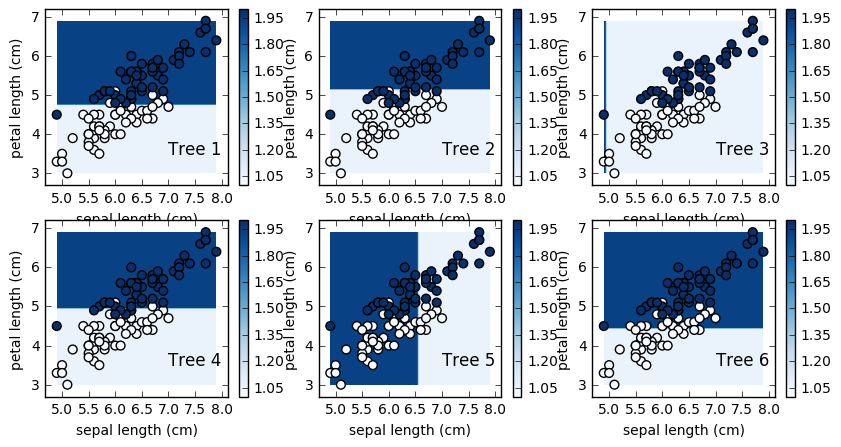

In [75]:
# build the model
clf = tree.DecisionTreeClassifier(max_depth=1)
mdl = ensemble.AdaBoostClassifier(base_estimator=clf,n_estimators=6)
mdl = mdl.fit(X,y)

# plot each individual decision tree
fig = plt.figure(figsize=[10,5])
for i, estimator in enumerate(mdl.estimators_):
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(estimator, X, y, feat)
    txt = 'Tree {}'.format(i+1)
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
plt.show()

Looking at the above, we can see that the first iteration builds the exact same simple decision tree as we had seen earlier. This makes sense - it's using the entire dataset with no special weighting. 

In the next iteration we can see the model shift - it misclassified five observations in class 1, and now these are the most important observations. Consequently, it picks the boundary that, while prioritizing correctly classifies these observations, still tries to best classify the rest of the data too. Now we have correctly classified all but one observation, the one on the far left middle of the graph. In iteration 3, the algorithm solely focuses on correctly classifying this one observation.

Let's look at final model's decision surface.

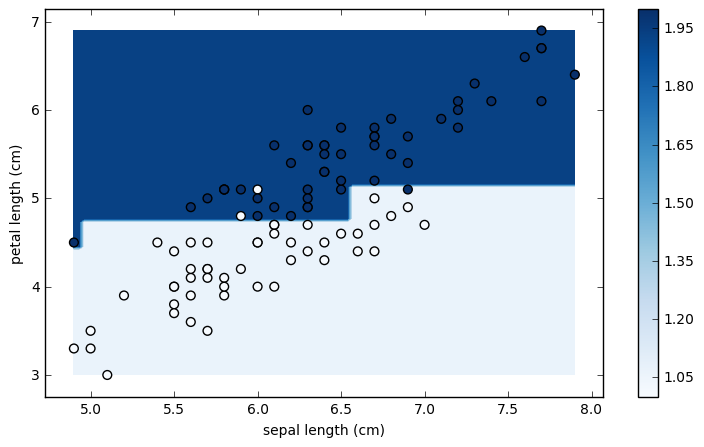

In [76]:
# plot the final prediction
plt.figure(figsize=[9,5])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

And that's AdaBoost! There are a few tricks we have glossed over here - but you understand the general principle. Now we'll move on to a different approach. With boosting, we iteratively changed the dataset to have new trees focus on the "difficult" observations. The next approach we discuss is similar as it also involves using changed versions of our dataset to build new trees.

## Bagging

Bootstrap aggregation, or "Bagging", is another form of *ensemble learning* where we aim to build a single good model by combining many models together. With AdaBoost, we modified the data to focus on hard to classify observations. We can imagine this as a form of resampling the data for each new tree. For example, say we have three observations: A, B, and C, `[A, B, C]`. If we correctly classify observations `[A, B]`, but incorrectly classify `C`, then AdaBoost involves building a new tree that focuses on `C`. Equivalently, we could say AdaBoost builds a new tree using the dataset `[A, B, C, C, C]`, where we have *intentionally* repeated observation `C` 3 times so that the algorithm thinks it is 3 times as important as the other observations. Before we move on, convince yourself that this makes sense.

Bagging involves the exact same approach, except we don't selectively choose which observations to focus on, but rather we *randomly select subsets of data each time*. As you can see, while this is a similar process to AdaBoost, the concept is quite different. Whereas before we aimed to iteratively improve our overall model with new trees, we now build trees on what we hope are independent datasets.

Let's take a step back, and think about a practical example. Say we wanted a good model of heart disease. If we saw researchers build a model from a dataset of patients from their hospital, we would be happy. If they then acquired a new dataset from new patients, and built a new model, we'd be inclined to feel that the combination of the two models would be better than any one individually. This exact scenario is what bagging aims to replicate, except instead of actually going out and collecting new datasets, we instead use bootstraping to create new sets of data from our current dataset. If you are unfamiliar with bootstrapping, you can treat it as "magic" for now (and if you are familiar with the bootstrap, you already know it's magic).

Let's take a look at a simple bootstrap model with the iris dataset.

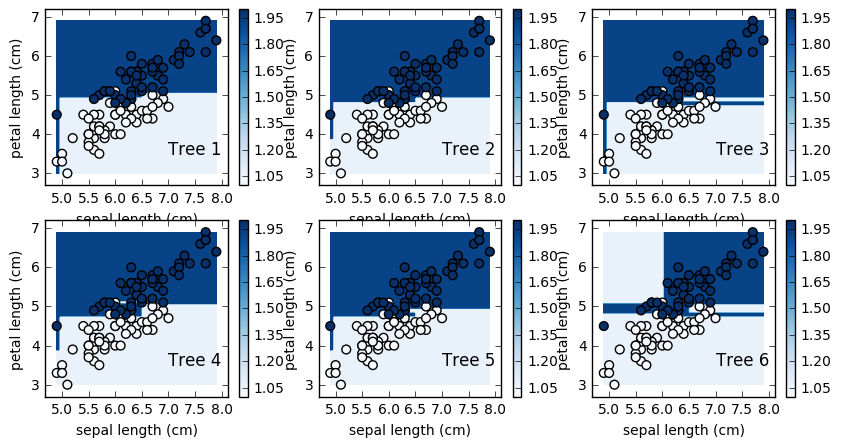

In [85]:
np.random.seed(321)
clf = tree.DecisionTreeClassifier(max_depth=5)
mdl = ensemble.BaggingClassifier(base_estimator=clf, n_estimators=6)
mdl = mdl.fit(X,y)

fig = plt.figure(figsize=[10,5])
for i, estimator in enumerate(mdl.estimators_):
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(estimator, X, y, feat)
    txt = 'Tree {}'.format(i+1)
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
plt.show()

We can see that each individual tree is quite variable - this is a result of using a random set of data to train the classifier.

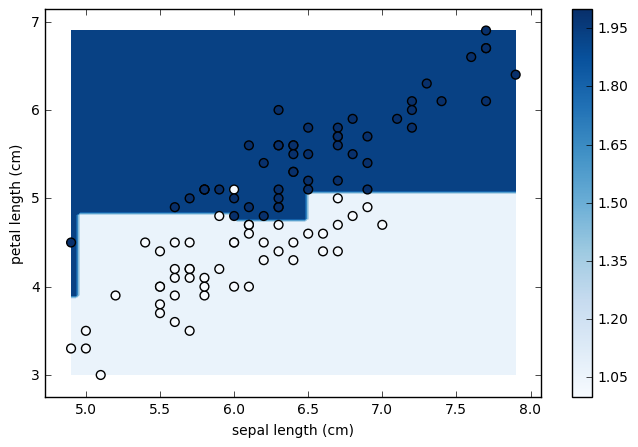

In [86]:
# plot the final prediction
plt.figure(figsize=[8,5])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

Not bad! Of course, since this is a simple dataset, we are not seeing that many dramatic changes between different models. Don't worry, we'll quantitatively evaluate them later.

Next up, a minor addition creates one of the most popular models in machine learning.

# Random Forest

Above, we used bagging to randomly resample our data to generate "new" datasets to build trees from. The Random Forest takes this one step further: instead of just resampling our data, we also select only a fraction of the features to include. It turns out that this subselection tends to improve the performance of our models. The odds of an individual being very good or very bad is higher (i.e. the variance of the trees is increased), and this ends up giving us a final model with better overall performance (lower bias).

Let's train the model now.

In [96]:
ensemble.RandomForestClassifier?

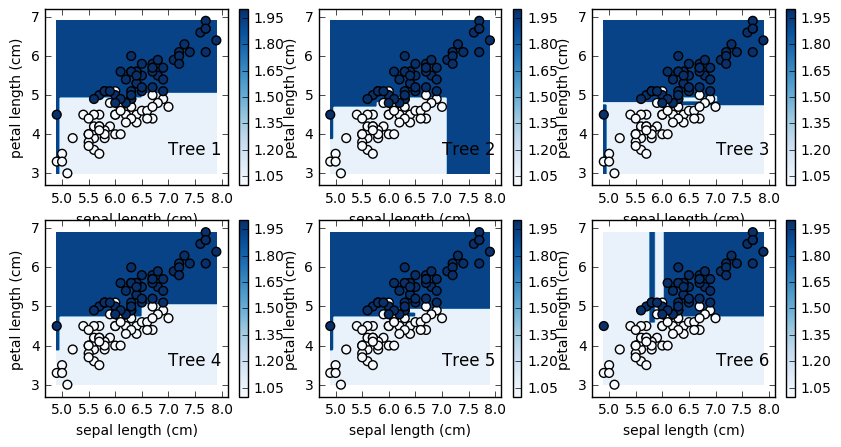

In [98]:
np.random.seed(321)
mdl = ensemble.RandomForestClassifier(max_depth=5, n_estimators=6, max_features=1)
mdl = mdl.fit(X,y)

fig = plt.figure(figsize=[10,5])
for i, estimator in enumerate(mdl.estimators_):
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(estimator, X, y, feat)
    txt = 'Tree {}'.format(i+1)
    plt.text(7.0, 3.5, txt, fontdict={'fontsize':12})
plt.show()

print('\nPlotting final decision surface\n')
plt.figure(figsize=[9,5])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

Again, the visualization doesn't *really* show us the power of Random Forests, but we'll quantitatively evaluate them soon enough.

Last, and not least, we move on to gradient boosting.

## Gradient Boosting

Gradient boosting is the our last topic - and perhaps the one that unifies the entire tutorial. Gradient boosting can be thought of as a generalization of all the previous methods.

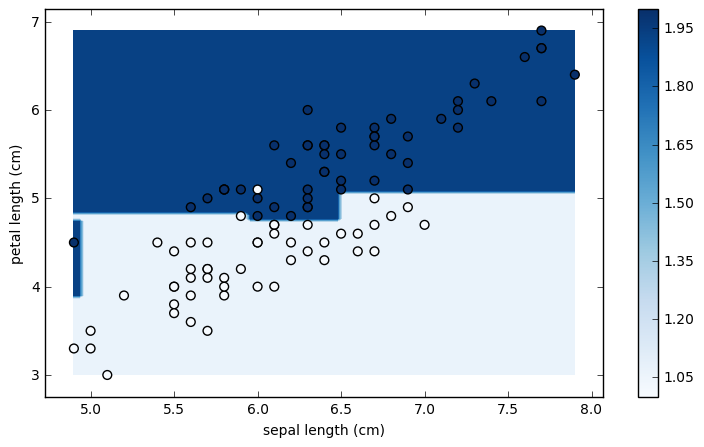

In [100]:
mdl = ensemble.GradientBoostingClassifier(n_estimators=10)
mdl = mdl.fit(X, y)


plt.figure(figsize=[9,5])
plot_model_pred_2d(mdl, X, y, feat)
plt.show()

# Running through a slightly harder dataset

Breast cancer dataset.

In [101]:
# real example
df = datasets.load_breast_cancer()

# if you want a description of the dataset, uncomment the below line
print(df['DESCR'])

# pick index of the features to use (only pick 2)
#    :Attribute Information (in order):
#        0 - CRIM     per capita crime rate by town
#        1 - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
#        2 - INDUS    proportion of non-retail business acres per town
#        3 - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#        4 - NOX      nitric oxides concentration (parts per 10 million)
#        5 - RM       average number of rooms per dwelling
#        6 - AGE      proportion of owner-occupied units built prior to 1940
#        7 - DIS      weighted distances to five Boston employment centres
#        8 - RAD      index of accessibility to radial highways
#        9 - TAX      full-value property-tax rate per $10,000
#       10 - PTRATIO  pupil-teacher ratio by town
#       11 - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#       12 - LSTAT    % lower status of the population
#       13 - MEDV     Median value of owner-occupied homes in $1000's


idx = [1,29]
X = df['data'][:,idx]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30, random_state=42)

feat = [x for x in df['feature_names'][idx]]

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

0.736842105263	Bagging
0.719298245614	AdaBoost
0.74269005848	Random Forest
0.748538011696	Gradient Boosting
0.684210526316	Decision Tree


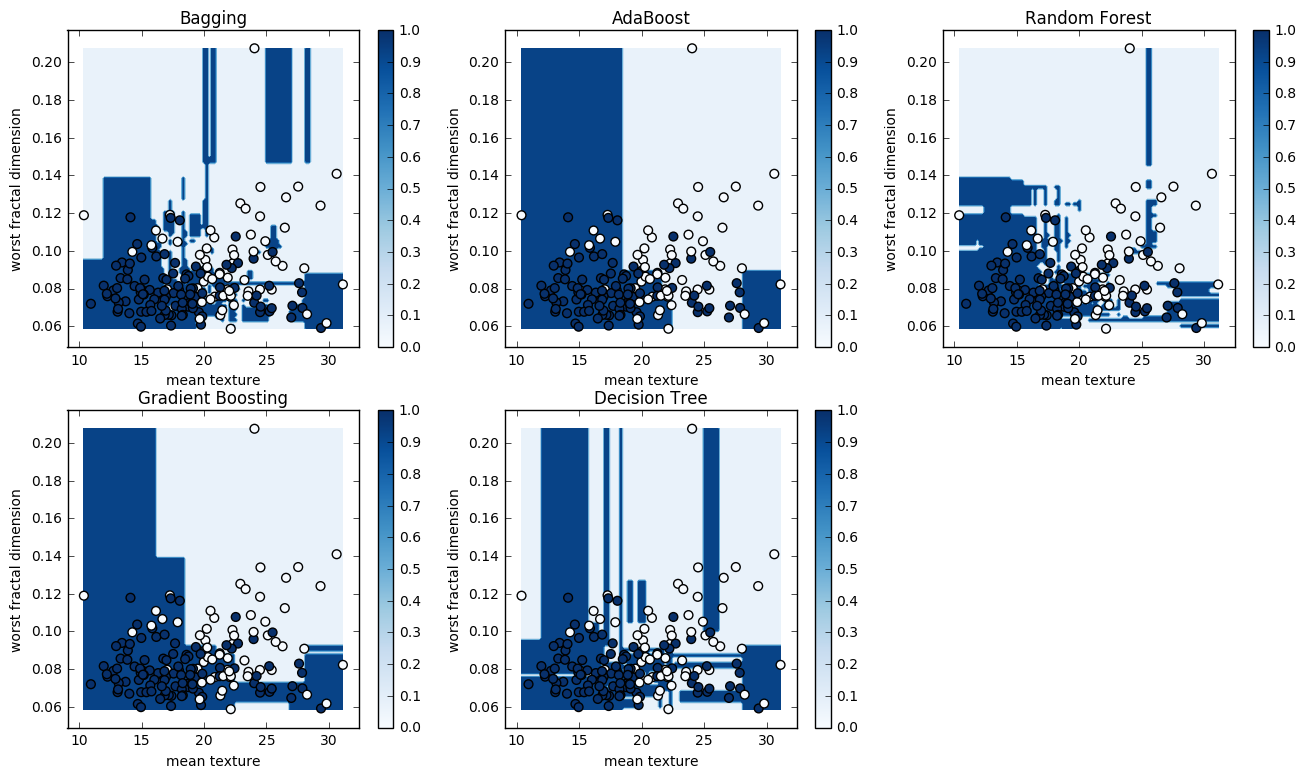

In [125]:
clf = dict()
clf['Decision Tree'] = tree.DecisionTreeClassifier(criterion='entropy', splitter='best').fit(X_train,y_train)
clf['Gradient Boosting'] = ensemble.GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train)
clf['Random Forest'] = ensemble.RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
clf['Bagging'] =  ensemble.BaggingClassifier(n_estimators=10).fit(X_train, y_train)
clf['AdaBoost'] =  ensemble.AdaBoostClassifier(n_estimators=10).fit(X_train, y_train)

fig = plt.figure(figsize=[16,9])
for i, curr_mdl in enumerate(clf):
    score = clf[curr_mdl].score(X_test, y_test)
    print('{}\t{}'.format(score, curr_mdl))
    
    ax = fig.add_subplot(2,3,i+1)
    plot_model_pred_2d(clf[curr_mdl], X_test, y_test, feat)
    
    plt.title(curr_mdl)
    
plt.show()

In [126]:
# even better, use cross-validation
print('Acc\tAUROC\tModel')
for curr_mdl in clf:
    scores = cross_val_score(clf[curr_mdl], X, y, cv=5, scoring='accuracy')
    auc = cross_val_score(clf[curr_mdl], X, y, cv=5, scoring='roc_auc')
    print('{:0.3f}\t{:0.3f}\t{}'.format(scores.mean(), auc.mean(), curr_mdl))

Acc	AUROC	Model
0.697	0.743	Bagging
0.728	0.786	AdaBoost
0.685	0.754	Random Forest
0.722	0.808	Gradient Boosting
0.685	0.653	Decision Tree


# Exercise

We'll now practice using these models on a dataset acquired from patients admitted to intensive care units at the Beth Israel Deaconness Medical Center in Boston, MA. All patients in the cohort stayed for at least 48 hours, and the goal of the prediction task is to predict in-hospital mortality. If you're interested, you can read more about the dataset here: http://physionet.org/challenge/2012/

The following command will download a "preprocessed" version of the dataset to the current directory. The data is originally provided as hourly observations for a number of variables, and the preprocessing step involved extracting summary statistics across all these observations.

Let's look at the first five features to get an idea of what this dataset looks like:

* build a single tree for each
* examine how the tree partitions the space
* explain how this works in terms of the cost function split on at each node

End of section exercise: build a decision tree using PhysionetChallenge2012_train.csv

# (Extra info) The Bootstrap

The bootstrap is a very popular method, and loosely speaking it allows one to repeatedly generate "new" datasets from the current dataset.